# Initial Setup

In [1]:
# For better sorting of column names in some exercises.
!pip install natsort

In [2]:
# Initial imports.
from typing import Tuple, List

import numpy as np
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from natsort import natsorted
from functools import partial
from ISLP import load_data
from l0bnb import fit_path

from matplotlib.pyplot import subplots
from matplotlib import pyplot as plt
from statsmodels.api import OLS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from ISLP.models import ModelSpec as MS
from ISLP.models import (
    Stepwise ,
    sklearn_selected ,
    sklearn_selection_path 
)

## Laboratory: Linear Models and Regularization Methods

### Subset Selection Methods

#### Forward Selection

In [3]:
Hitters = load_data("Hitters")

np.isnan(Hitters["Salary"]).sum()

59

In [4]:
Hitters: pd.DataFrame = Hitters.dropna()

# Show it.
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [5]:
def nCp(sigma2, estimator, X, Y):
    """
    Negative Cp statistic.
    """
    
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    
    return -(RSS + 2 * p * sigma2) / n

In [6]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)

Y: np.array = np.array(Hitters["Salary"])
X: pd.DataFrame = design.transform(Hitters)

sigma2: float = OLS(Y,X).fit().scale

sigma2

99591.3561796822

In [7]:
neg_Cp = partial(nCp, sigma2)
neg_Cp?

Signature:      neg_Cp(estimator, X, Y)
Call signature: neg_Cp(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function nCp at 0x7fbe6732beb0>, 99591.3561796822)
File:           /usr/lib/python3.10/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.

In [8]:
strategy = Stepwise.first_peak(
    model_spec=design,
    direction="forward",
    max_terms=len(design.terms)
)

In [9]:
%%time

hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

CPU times: user 1.73 s, sys: 0 ns, total: 1.73 s
Wall time: 1.73 s


('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [10]:
%%time

hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.1 s


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [11]:
strategy = Stepwise.fixed_steps(
    design,
    len(design.terms),
    direction='forward'
)

full_path = sklearn_selection_path(OLS, strategy)
full_path

sklearn_selection_path(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                       strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7fbe6705d030>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=functools.partial(<function fixed_steps at 0x7fbe67328b80>, 19), postprocess=functools.partial(<function _postprocess_fixed_steps at 0x7fbe67328ca0>, 19)))

In [12]:
%%time

full_path.fit(Hitters, Y)
Yhat_in: np.ndarray = full_path.predict(Hitters)
Yhat_in.shape

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.05 s


(263, 20)

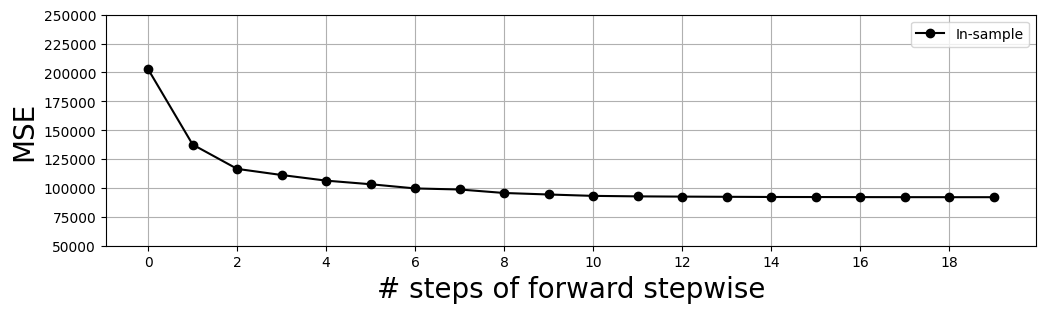

In [13]:
mse_fig, ax = subplots(figsize=(12, 3))

insample_mse: np.ndarray = ((Yhat_in - Y[:, None]) ** 2).mean(0)
n_steps: int = insample_mse.shape[0]

ax.plot(
    np.arange(n_steps),
    insample_mse,
    marker="o",
    color="k",  # color black
    label="In-sample"
)
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("# steps of forward stepwise", fontsize=20)
ax.set_xticks(np.arange(n_steps))
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.grid()
ax.set_ylim([50000, 250000]);

In [14]:
%%time

K: int = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv: np.ndarray = skm.cross_val_predict (full_path, Hitters, Y, cv=kfold)

Yhat_cv.shape

CPU times: user 5.17 s, sys: 0 ns, total: 5.17 s
Wall time: 5.17 s


(263, 20)

In [15]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):

    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    
    # Column means.
    cv_mse.append(errors.mean(0))  

cv_mse = np.array(cv_mse).T

cv_mse.shape

(20, 5)

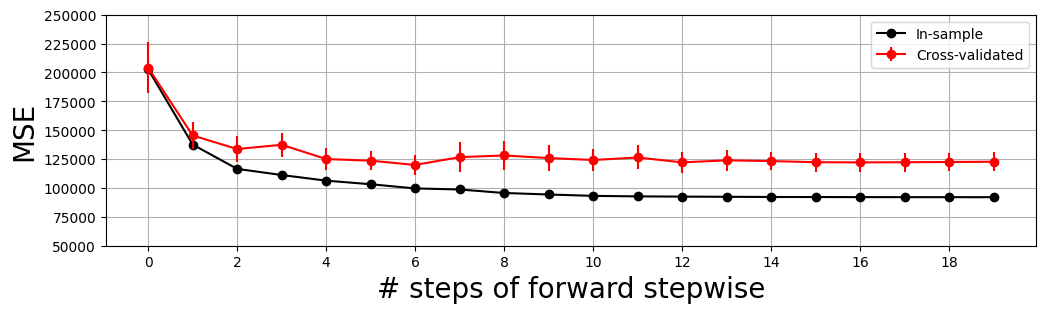

In [16]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(axis=1),
    cv_mse.std(axis=1) / np.sqrt(K),
    label="Cross-validated",
    color="red",
    marker="o"
)

ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [17]:
validation = skm.ShuffleSplit(
    n_splits=1, test_size=0.2, random_state=0
)

for train_idx, test_idx in validation.split(Y):
    
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    
    validation_mse = errors.mean(0)

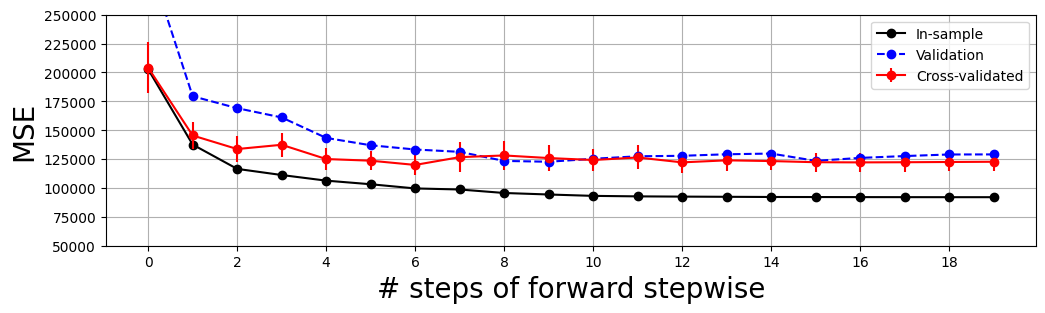

In [18]:
ax.plot(
    np.arange(n_steps), 
    validation_mse, 
    marker="o",
    color="blue",
    linestyle="--", # color blue, broken line
    label="Validation")

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

#### Best Subset Selection

In [19]:
D = design.fit_transform(Hitters)
D = D.drop("intercept", axis=1)
X = np.asarray(D)

X.shape

(263, 19)

In [20]:
%%time

path = fit_path(X, Y, max_nonzeros=X.shape[1])
path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19
CPU times: user 3min 5s, sys: 0 ns, total: 3min 5s
Wall time: 4.35 s


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

### Ridge Regression and the Lasso

## Exercises

### Conceptual

### Applied

#### Ancillar Functions

In [21]:
def adjust_linear_model(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[OLS, float, float, float, float]:
    """
    Adjust a linear model with all predictors.
    """
    
    linear_model = OLS(endog=dfY, exog=dfX).fit()

    return linear_model, linear_model.ssr, linear_model.rsquared, linear_model.bic, linear_model.aic


def forward_stepwise_selection(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[List[int], List[float], List[float], List[float], List[float], List[float], List[OLS]]:
    """
    Forward stepwise selection.
    """
    
    print(">>> Starting forward stepwise selection...")

    # Initially all predictor are available.
    all_features: List[str] = dfX.columns.to_list()
    available_features: List[str] = dfX.columns.to_list()
    used_features: List[str] = []

    # Initialize some metrics to be used as a function of the number of used features.
    n_features: List[int] = []
    rss_list: List[float] = []
    r2_list: List[float] = []
    bic_list: List[float] = []
    aic_list: List[float] = []
    cp_list: List[float] = []
    best_models: List[OLS] = []

    # Initialize best Cp as very low.
    best_cp: float = -np.inf

    while len(used_features) < len(all_features):

        # Loop over all predictors.
        for feature in available_features:
            
            # If feature not already used.
            if feature not in used_features:

                # Candidates to test.
                tested_features: List[str] = used_features + [feature]

                print(f">>> Testing features: {tested_features}")

                # Fit model with current feature.
                model, rss, r2, bic, aic = adjust_linear_model(dfX[tested_features], dfY)

                # Calculate cp.
                cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])

                print(f"\t* metrics: CP={cp:.2f} (bestCP={best_cp:.2f}), RSS={rss:.2f}, R2={r2:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")

                # Verify if the model is better according to Cp.
                if cp > best_cp:

                    # Update best metrics.
                    best_cp: float = cp
                    best_rss: float = rss
                    best_r2: float = r2
                    best_bic: float = bic
                    best_aic: float = aic

                    # Update best feature.
                    best_feature: str = feature

                    # Best model.
                    best_model: OLS = model

        # Update lists.
        used_features.append(best_feature)
        n_features.append(len(used_features))
        rss_list.append(best_rss)
        r2_list.append(best_r2)
        bic_list.append(best_bic)
        aic_list.append(best_aic)
        cp_list.append(best_cp)
        available_features.remove(best_feature)
        best_models.append(best_model)

        print(f"\t* Diagnostic: used features: {used_features}, Cp: {best_cp}, RSS: {best_rss}, R2: {best_r2}")

        # Reset best Cp for next round.
        best_cp = -np.inf

    print("\n>>> Done!")    

    return n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models


# Skeleton for backward stepwise selection.
# all_features: List[str] = dfX.columns.to_list()
# tested_features: List[str] = all_features.copy()
# candidates: List[str] = all_features.copy()

# # Adjust linear model with all predictors.
# model, rss, r2, bic, aic = adjust_linear_model(dfX, dfY)

# print(f">>> Testing features: {tested_features}")

# # Loop over candidates to be removed.
# for candidate in all_features:

#     # Is this a valid candidate?
#     if candidate in candidates:

#         # Features to be tested.
#         tested_features = natsorted(list(set(candidates) - set([candidate])))

#         print(f">>> Testing features: {tested_features}")

#         # Adjust model and calculate metrics.
#         pass

#         # Update lists.
#         pass
   
#     # Select feature to be removed.
#     removed_feature = np.random.choice(candidates)
#     candidates.remove(removed_feature)    

#### 8

In [22]:
# a)

# Random predictors and noise.
X: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))
eps: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))

In [23]:
# b)

# Real parameters that generate data.
B0: float = 5.0
B1: float = -10.0
B2: float = 3.0
B3: float = 14.0

# Response.
Y: np.ndarray = B0 + B1*X + B2*(X**2) + B3*(X**3) + eps

# To dataframes.
dfY: pd.DataFrame = pd.DataFrame(Y, columns=["Y"])
dfY

,Y
0,82.649267
1,2.655417
2,3.119810
3,2.608610
4,5.249320
...,...
95,8.723231
96,-25.979750
97,3.773208
98,-92.783355


In [24]:
# c)

# As dataframe with intercept.
Features: np.ndarray = np.hstack([X**i for i in range(0, 11)])
dfX = pd.DataFrame(Features, columns=[f"X{i}" for i in range(0, 11)])
dfX

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.0,1.836629,3.373207,6.195331,11.378525,20.898133,38.382122,70.493727,1.294708e+02,2.377899e+02,4.367319e+02
1,1.0,0.472932,0.223665,0.105778,0.050026,0.023659,0.011189,0.005292,2.502601e-03,1.183561e-03,5.597441e-04
2,1.0,0.708243,0.501608,0.355261,0.251611,0.178202,0.126210,0.089388,6.330809e-02,4.483753e-02,3.175587e-02
3,1.0,0.161645,0.026129,0.004224,0.000683,0.000110,0.000018,0.000003,4.661148e-07,7.534501e-08,1.217912e-08
4,1.0,0.348824,0.121678,0.042444,0.014806,0.005165,0.001802,0.000628,2.192043e-04,7.646366e-05,2.667235e-05
...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,-0.302785,0.091679,-0.027759,0.008405,-0.002545,0.000771,-0.000233,7.064426e-05,-2.139003e-05,6.476585e-06
96,1.0,-1.549000,2.399401,-3.716673,5.757126,-8.917789,13.813656,-21.397355,3.314450e+01,-5.134084e+01,7.952697e+01
97,1.0,0.228214,0.052081,0.011886,0.002712,0.000619,0.000141,0.000032,7.357552e-06,1.679094e-06,3.831922e-07
98,1.0,-2.108796,4.447021,-9.377860,19.775993,-41.703535,87.944250,-185.456485,3.910899e+02,-8.247288e+02,1.739185e+03


In [25]:
# Adjust a linear model with all predictors.
linear_model = OLS(endog=dfY, exog=dfX).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.593e+04
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          3.56e-140
Time:                        14:42:18   Log-Likelihood:                -151.55
No. Observations:                 100   AIC:                             325.1
Df Residuals:                      89   BIC:                             353.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0             5.0379      0.214     23.542      0.000       4.613       5.463
X1           -10.2945      0.703    -14.646      0.000     -11.691      -8.898
X2             3.4214      1.165      2.936      0.004       1.106       5.737
X3            13.7247      1.987      6.907      0.000       9.777      17.673
X4            -1.2962      1.470     -0.882      0.380      -4.217       1.625
X5             0.6358      1.635      0.389      0.698      -2.613       3.885
X6             0.7912      0.722      1.096      0.276      -0.643       2.226
X7            -0.2026      0.482     -0.420      0.676      -1.161       0.756
X8            -0.1716      0.168     -1.024      0.309      -0.505       0.161
X9             0.0176      0.046      0.382      0.703      -0.074       0.109
X10            0.0122      0.015      0.809      0.421      -0.018       0.042
==============================================================================
Omnibus:                        0.746   Durbin-Watson:                   2.307
Prob(Omnibus):                  0.689   Jarque-Bera (JB):                0.346
Skew:                           0.097   Prob(JB):                        0.841
Kurtosis:                       3.214   Cond. No.                     9.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# Model selection criterion scorer.
sigma2 = linear_model.scale
neg_Cp = partial(nCp , sigma2)

In [27]:
# Run forward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = forward_stepwise_selection(dfX, dfY)

>>> Starting forward stepwise selection...
>>> Testing features: ['X0']
	* metrics: CP=-2171.75 (bestCP=-inf), RSS=217172.25, R2=0.00, BIC=1056.72, AIC=1054.12
>>> Testing features: ['X1']
	* metrics: CP=-1013.52 (bestCP=-2171.75), RSS=101348.82, R2=0.53, BIC=980.51, AIC=977.90
>>> Testing features: ['X2']
	* metrics: CP=-1793.73 (bestCP=-1013.52), RSS=179369.78, R2=0.18, BIC=1037.60, AIC=1034.99
>>> Testing features: ['X3']
	* metrics: CP=-82.36 (bestCP=-1013.52), RSS=8233.35, R2=0.96, BIC=729.47, AIC=726.87
>>> Testing features: ['X4']
	* metrics: CP=-1267.22 (bestCP=-82.36), RSS=126719.10, R2=0.42, BIC=1002.85, AIC=1000.24
>>> Testing features: ['X5']
	* metrics: CP=-200.37 (bestCP=-82.36), RSS=20034.47, R2=0.91, BIC=818.40, AIC=815.79
>>> Testing features: ['X6']
	* metrics: CP=-991.52 (bestCP=-82.36), RSS=99149.57, R2=0.54, BIC=978.31, AIC=975.71
>>> Testing features: ['X7']
	* metrics: CP=-376.90 (bestCP=-82.36), RSS=37687.44, R2=0.83, BIC=881.58, AIC=878.98
>>> Testing features:

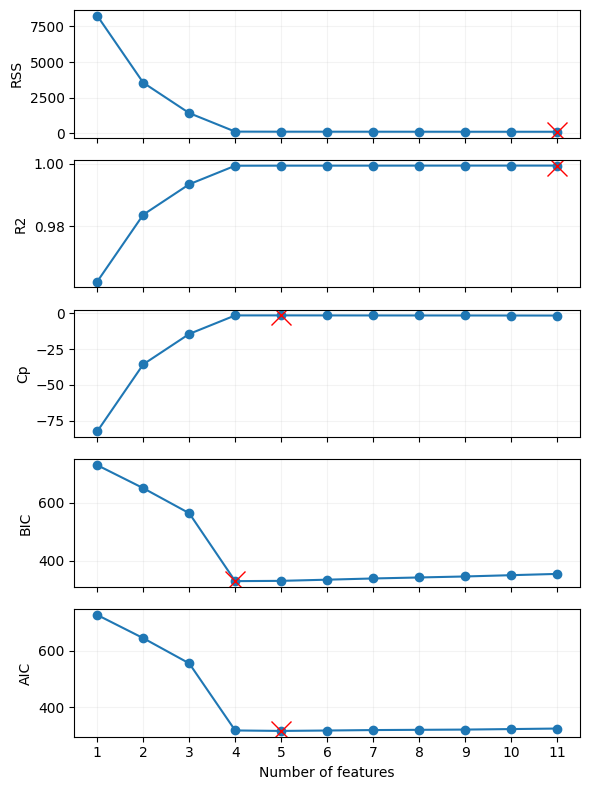

In [28]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

plt.tight_layout()

In [29]:
# Expected coefficients.
df_compare: pd.DataFrame = pd.DataFrame({
    "true": [B0, B1, B2, B3] + [0.0]*7
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_adjusted_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="adjusted_cp")
df_adjusted_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="adjusted_bic")
df_adjusted_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="adjusted_aic")
df_adjusted_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="adjusted_r2")

# Join all dataframes.
df_compare = df_compare.join(df_adjusted_cp, how="outer")
df_compare = df_compare.join(df_adjusted_bic, how="outer")
df_compare = df_compare.join(df_adjusted_aic, how="outer")  
df_compare = df_compare.join(df_adjusted_r2, how="outer")

# Reduce float precision.
df_compare = df_compare.round(3)

# Better sorting of the index.
df_compare = df_compare.reindex(natsorted(df_compare.index))

df_compare

,true,adjusted_cp,adjusted_bic,adjusted_aic,adjusted_r2
X0,5.0,5.045,4.976,5.045,5.038
X1,-10.0,-10.419,-9.988,-10.419,-10.294
X2,3.0,2.888,3.007,2.888,3.421
X3,14.0,14.440,14.030,14.440,13.725
X4,0.0,NaN,NaN,NaN,-1.296
X5,0.0,-0.056,NaN,-0.056,0.636
X6,0.0,NaN,NaN,NaN,0.791
X7,0.0,NaN,NaN,NaN,-0.203
X8,0.0,NaN,NaN,NaN,-0.172
X9,0.0,NaN,NaN,NaN,0.018
